In [1]:
import pyBigWig
import os
import hmap
import pybedtools
import glob
import sys
import matplotlib.pyplot as plt
import pandas as pnd
import gelviz
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_folder = "" # path to folder where data from https://zenodo.org/record/4557352 (DOI: 10.5281/zenodo.4557352) is stored
fpkm_matrix_filename = data_folder+os.sep+"/fpkm_matrix_human.csv"
samples_dict = {"normal": ["Parotid Gland3", "Parotid Gland4", "Parotid_Gland2"],
                "tumor": ["AciCC1", "AciCC3", "AciCC8", "AciCC4", "AciCC10", "AciCC9", "AciCC6", "AciCC5", "AciCC2", "AciCC7"]}

# File´s used for gene plotting
gelviz_repo_path = "" # Path to clone of https://github.com/HiDiHlabs/gelviz
genes_bed_filename = gelviz_repo_path+os.sep+"data/gencode.v19.annotation.genes_genes.bed"
exons_bed_filename = gelviz_repo_path+os.sep+"data/gencode.v19.annotation.genes_exons.bed"
introns_bed_filename = gelviz_repo_path+os.sep+"data/gencode.v19.annotation.genes_introns.bed"
gene_map_filename = gelviz_repo_path+os.sep+"data/gencode_v19_ENSGID_GENENAME.tsv"

samples = ["AciCC1", "AciCC2", "AciCC3", "Parotid_Gland1", "Parotid_Gland2", "Parotid_Gland3", "Parotid_Gland4"]
chip_types = ["H3K27Ac", "H3K4me3", "H3K27me3", "CTCF", "NR4A3", "super_enhancer"]

chip_color_dict = {"H3K27Ac": "#e31a1c",
                   "H3K4me3": "#ff7f00",
                   "H3K27me3": "#1f76b4",
                   "CTCF": "#737373",
                   "NR4A3": "#bc36cc",
                   "super_enhancer": "k"}

ylim_dict = {"H3K27Ac": [0, 100],
                   "H3K4me3": [0, 100],
                   "H3K27me3": [0, 100],
                   "CTCF": [0, 30],
                   "NR4A3": [0, 20]}

In [3]:
# Create a gene_id_map
gene_map_file = open(gene_map_filename, "r")
gene_id_map = {}
for line in gene_map_file:
    split_line = line.rstrip().split("\t")
    
    ensembl_gene_id = split_line[0].split(".")[0]
    hugo_gene_symbol = split_line[1]
    
    gene_id_map[ensembl_gene_id] = hugo_gene_symbol
gene_map_file.close()

In [4]:
fpkm_matrix_df = pnd.read_csv(fpkm_matrix_filename, sep="\t", index_col = 14)

# Create a browser like plot containing

1. Genomic coordinates
2. Genes
3. ChIP seq signal tracks
4. ChIP seq peak tracks
5. Methylation profiles

In [5]:
n_signal_tracks = len(glob.glob(data_folder+os.sep+"*_chip_signal_*"))
n_peak_tracks = len(glob.glob(data_folder+os.sep+"*_peaks_*"))
n_methylation_tracks = len(glob.glob(data_folder+os.sep+"*_methylationCalls_*"))

region = ["4", 70538611, 71191210]
region_bed = pybedtools.BedTool("\t".join([str(e) for e in region]), from_string = True)

genes_bed = pybedtools.BedTool(genes_bed_filename)
introns_bed = pybedtools.BedTool(introns_bed_filename)
exons_bed = pybedtools.BedTool(exons_bed_filename)

['70.6Mb', '70.7Mb', '70.8Mb', '70.9Mb', '71.0Mb', '71.1Mb']


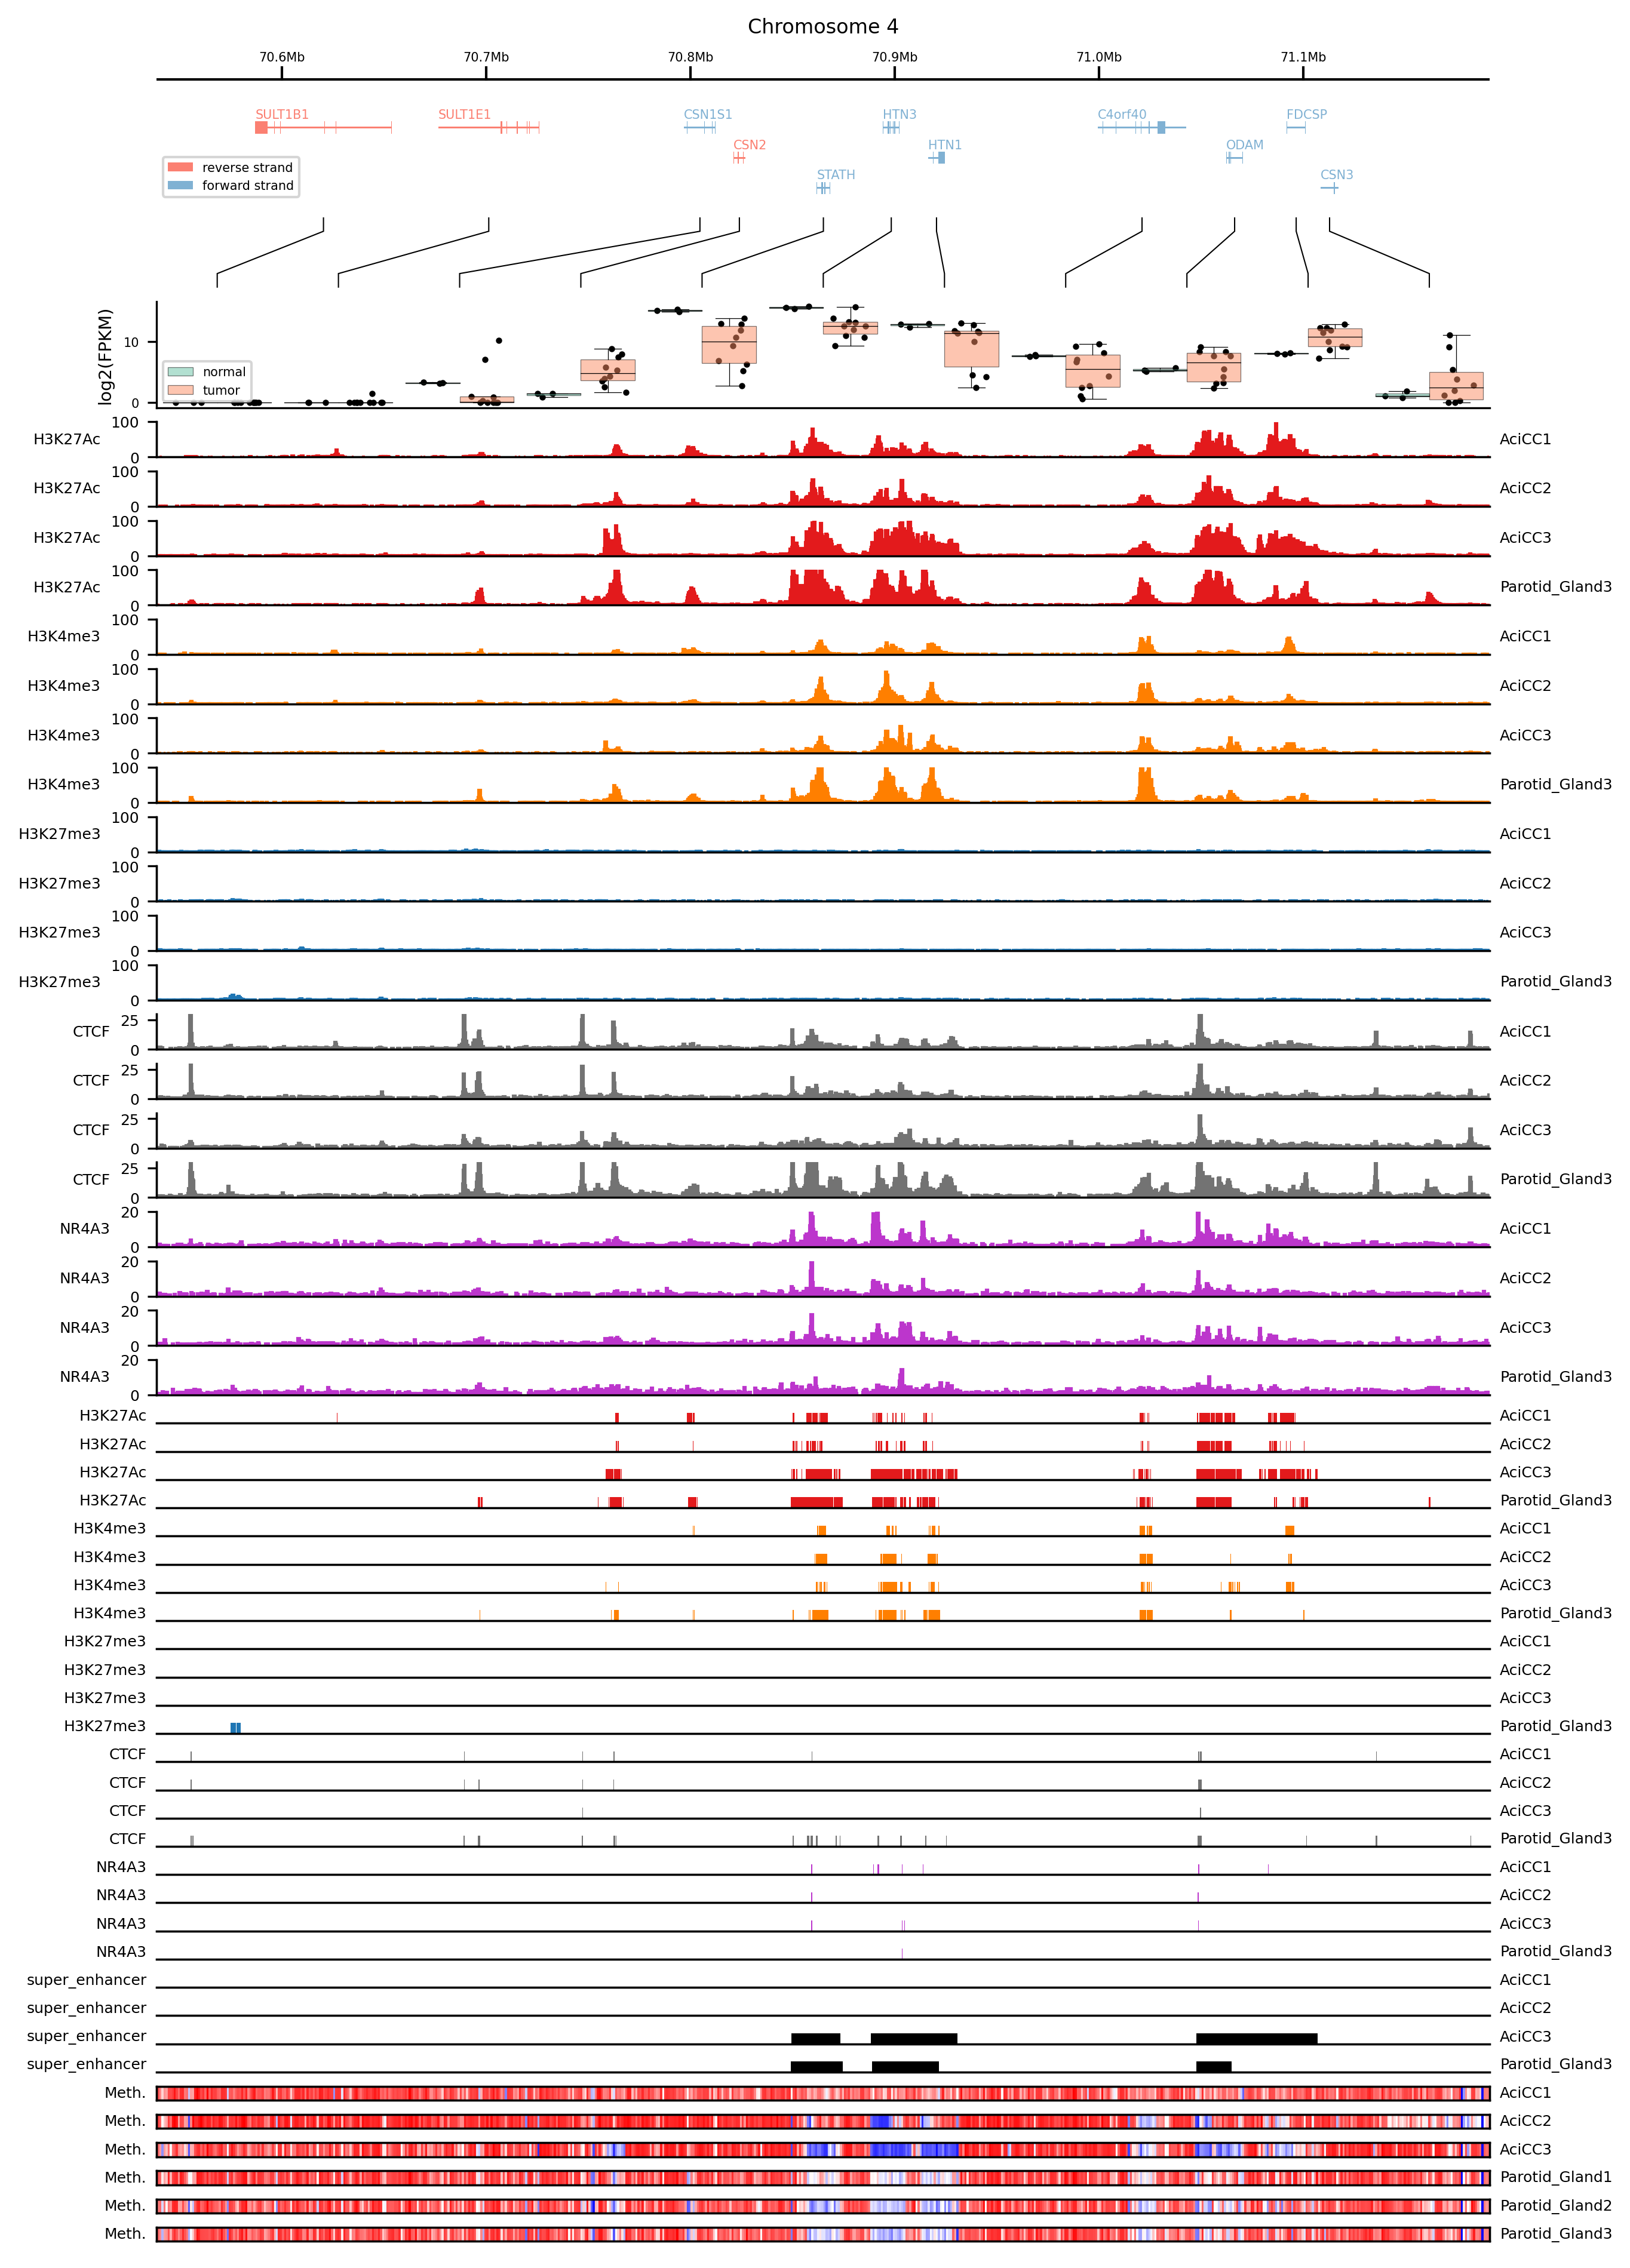

In [6]:
%autoreload 2

plot_filename = "pics/salivary_gland_locus_acicc.jpeg"

# Create a figure grid
fig, gs = hmap.layout.layout.layoutGrid(4+n_signal_tracks+n_peak_tracks+n_methylation_tracks,
                                        1,
                                        [189.],
                                        [5., 15., 10., 15.,]+n_signal_tracks*[5.]+n_peak_tracks*[2.]+n_methylation_tracks*[2.],
                                        2.,
                                        1.,
                                        10.,
                                        20.,
                                        25.,
                                        25.)

# Plot genomic coordinates
ax = plt.subplot(gs[0,0])
plt.title("Chromosome "+str(region[0]), fontsize=8)
gelviz.basic.plotCoordinates(region[0], 
                             region[1], 
                             region[2],
                             ax = ax,
                             upper=True)

# Plot genes
ax = plt.subplot(gs[1, 0])
gelviz.basic.plotGenes(genes_bed.intersect(region_bed, wa=True),
                       exons_bed.intersect(region_bed, wa=True),
                       introns_bed.intersect(region_bed, wa=True),
                       region_bed,
                       gene_map = gene_id_map,
                       ax = ax,
                       plot_legend = True,
                       legend_loc = "lower left")
ax.axis("off")

# Plot Gene Distance Equalizer
ax = plt.subplot(gs[2, 0])
gene_mid_points = gelviz.basic.distanceEqualizer(genes_bed.intersect(region_bed, wa=True),
                               region[1],
                               region[2],
                               ax = ax)

# Plot Gene Expression
ax = plt.subplot(gs[3, 0])
gelviz.basic.plotGeneExpressionEqualDist(genes_bed.intersect(region_bed, wa=True),
                                         gene_mid_points,
                                         region,
                                         fpkm_matrix_df,
                                         groups=[samples_dict["normal"], samples_dict["tumor"]],
                                         ids=["normal", "tumor"],
                                         gene_names_map = gene_id_map,
                                         ax = ax,
                                         plot_legend = True,
                                         plot_gene_names = False,
                                         plot_points = True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks([], [])
plt.ylabel("log2(FPKM)", fontsize=7)

# Plot ChIP-Signals
chip_plot_idx = 0
for chip_type in chip_types:
    for sample in samples:
        signal_filename = glob.glob(data_folder+os.sep+sample+"_"+chip_type+"_chip_signal_*")
        if(not(len(signal_filename) == 1)):
            continue
            
        signal_filename = signal_filename[0]
        bw = pyBigWig.open(signal_filename)
        signal_list = [ [region[0], i[0], i[1], i[2]] for i in bw.intervals(region[0], region[1], region[2]) ]
        
        color =chip_color_dict[chip_type]
        
        ax = plt.subplot(gs[4+chip_plot_idx])
        plt.yticks(fontsize=6)
        ax2 = ax.twinx()
        plt.yticks([], [])
        gelviz.basic.plotChIPSignals(signal_list,
                                     region[0],
                                     region[1],
                                     region[2],
                                     ax = ax,
                                     offset = 100,
                                     merge = 10,
                                     color = color)
        
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xticks([], [])
        ax.set_ylim(ylim_dict[chip_type])
        ax2.spines["top"].set_visible(False)
        ax2.spines["right"].set_visible(False)
        ax2.set_xticks([], [])
        ax2.set_ylim(ylim_dict[chip_type])
        ax.set_ylabel(chip_type, 
                   fontsize=6, 
                   rotation = 0,
                   horizontalalignment = "right",
                   verticalalignment = "center")
        
        ax2.yaxis.set_label_position("right")
        ax2.set_ylabel(sample,
                  fontsize=6, 
                   rotation = 0,
                   horizontalalignment = "left",
                   verticalalignment = "center")
        
        plt.yticks(fontsize=6)
        
        chip_plot_idx += 1

# Plot ChIP-peaks
chip_peak_idx = 0
for chip_type in chip_types:
    for sample in samples:
        peak_filename = glob.glob(data_folder+os.sep+sample+"_"+chip_type+"_peaks_*")
        if(not(len(peak_filename) == 1)):
            continue
        peak_filename = peak_filename[0]
        
        peak_bed = pybedtools.BedTool(peak_filename)
        
        region_chr_bed = pybedtools.BedTool("\t".join(["chr"+region[0], 
                                                       str(region[1]), 
                                                       str(region[2])]), 
                                            from_string=True)
        
        ax = plt.subplot(gs[4+chip_plot_idx+chip_peak_idx])
        plt.yticks([], [])
        ax2 = ax.twinx()
        plt.yticks([], [])
        gelviz.basic.plotRegions(peak_bed.intersect(region_chr_bed, wa=True),
                                 region[1],
                                 region[2],
                                 color = chip_color_dict[chip_type],
                                 edgecolor=False,
                                 ax = ax)
        ax.set_ylabel(chip_type, 
                   fontsize=6, 
                   rotation = 0,
                   horizontalalignment = "right",
                   verticalalignment = "center")
        
        ax2.yaxis.set_label_position("right")
        ax2.set_ylabel(sample,
                  fontsize=6, 
                   rotation = 0,
                   horizontalalignment = "left",
                   verticalalignment = "center")
        
        #ax. axis("off")
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax2.spines["top"].set_visible(False)
        ax2.spines["left"].set_visible(False)
        ax2.spines["right"].set_visible(False)
        chip_peak_idx += 1

# Plot Methylation Profiles
methylation_idx = 0
for sample in samples:
    meth_filename = glob.glob(data_folder+os.sep+sample+"_"+"methylationCalls"+"*")
    if(not(len(meth_filename) == 1)):
        continue
    meth_filename = meth_filename[0]
    meth_bed = pybedtools.BedTool(meth_filename)
    
    meth_list = [ [str(e[0]), 
                   int(e[1]),
                   int(e[2]),
                   int(e[4]),
                   int(e[5])] for e in meth_bed.intersect(region_bed, wa=True) ]
    
    ax = plt.subplot(gs[4+chip_plot_idx+chip_peak_idx+methylation_idx])
    plt.yticks([], [])
    ax2 = ax.twinx()
    plt.yticks([], [])
    gelviz.basic.plotMethylationProfileHeat(meth_list,
                                            region[0],
                                            region[1],
                                            region[2],
                                            ax = ax)
    ax.set_ylabel("Meth.", 
               fontsize=6, 
               rotation = 0,
               horizontalalignment = "right",
               verticalalignment = "center")
    
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(sample,
                  fontsize=6, 
                   rotation = 0,
                   horizontalalignment = "left",
                   verticalalignment = "center")
    
    methylation_idx += 1
    
plt.savefig(plot_filename)